In [2]:
import numpy as np
from landlab import RasterModelGrid
from landlab.components import SoilInfiltrationGreenAmpt
from landlab.io import read_esri_ascii
from landlab import imshow_grid
import time
from landlab.components import OverlandFlow
from landlab import RasterModelGrid, CLOSED_BOUNDARY, FIXED_VALUE_BOUNDARY

from matplotlib import pyplot as plt
import matplotlib as mpl

import sys, os.path
topopath=os.path.join("..","topographies")

%matplotlib inline

In [3]:
#Topography

# (rmg, z) = read_esri_ascii(os.path.join(topopath,'flat_[30,30,20][60.0,0.0].asc'), name='topographic__elevation')
(rmg, z) = read_esri_ascii(os.path.join(topopath,'clipped2cropped2.asc'), name='topographic__elevation')

rows = rmg.shape[0]
cols = rmg.shape[1]

rows2 = rows // 2 #make interger

In [4]:
#Initial values:

#Depth of water above the surface
h = rmg.add_ones('node', 'surface_water__depth')
h *= 0.01

#Water column height above the surface previously absorbed into the soil. 
#Note that this is NOT the actual depth of the wetted front, which also depends on the porosity.
d = rmg.add_ones('node', 'soil_water_infiltration__depth', dtype=float)
d *= 0.2

#Overland flow
alpha = 0.4 #weight on the adaptive time step 
mannings_n = 0.055 #first estimation for urban average value
# mannings_n_max = 0.06

# mannings_n = rmg.ones('node')*mannings_n_min
# mannings_n += np.random.rand(z.size)*(mannings_n_max - mannings_n_min)  #to randomize manning n

#Storm conditions
# storm_flag = '1995-11-18'
# storm_flag = '1997-03-11'
# storm_flag = '2009-02-10'
# storm_flag = '2010-12-08'
storm_flag = '2012-11-24'

#Soil type:
soil_type = 'loam'

#Hydraulic Conductivity
#the ease with which a fluid (usually water) can move through pore spaces or fractures.
#typical values for conductivity: http://www.aqtesolv.com/aquifer-tests/aquifer_properties.htm
# #clay:
# min_h = 1e-11
# max_h = 4.7e-9

#gravel:
min_h = 2e-6
max_h = 3e-6

hydraulic_conductivity = rmg.ones('node')*min_h
hydraulic_conductivity += np.random.rand(z.size)*(max_h - min_h)  #to randomize hydraulic conductivity

#Run time:
model_run_time = 3600.0*8 # seconds.hours

switch_plot_inter = 0

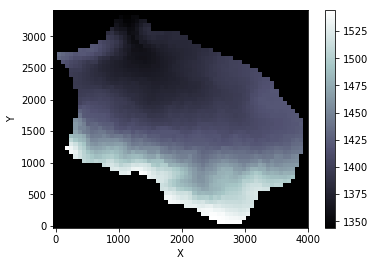

In [5]:
#Boundary Conditions:

#To set values to BOUNDARIES:

# for edge in (rmg.nodes_at_right_edge):
#     rmg.status_at_node[edge] = FIXED_VALUE_BOUNDARY
# for edge in (rmg.nodes_at_left_edge, rmg.nodes_at_top_edge, rmg.nodes_at_bottom_edge):
#     rmg.status_at_node[edge] = CLOSED_BOUNDARY

#To set lowest node as open, and rest closed:

noDataValue = -99999

rmg.set_watershed_boundary_condition(z, nodata_value=noDataValue)

# rtn = rmg.set_watershed_boundary_condition(z, return_outlet_id = True)

imshow_grid(rmg, 'topographic__elevation', cmap='bone')

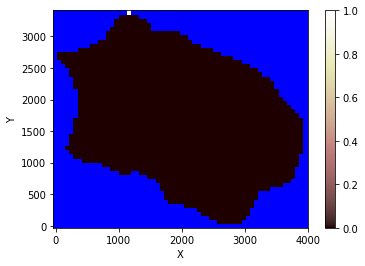

In [6]:
#Visualise Boundary Conditions:

imshow_grid(rmg, rmg.status_at_node,color_for_closed='blue')

In [7]:
#info of outlet node and links, to help find correct link:

outlet_node = np.where(rmg.status_at_node==1)
print(outlet_node)

print(rmg.links_at_node[outlet_node])
print(rmg.status_at_link[rmg.links_at_node[outlet_node]])
print(rmg.active_link_dirs_at_node[outlet_node])
print(rmg.node_at_link_head[outlet_node])
print(rmg.node_at_link_tail[outlet_node])
print(rmg.calc_grad_at_link(z)[rmg.links_at_node[outlet_node]])
# print(rmg['node']['topographic__elevation'][outlet_node])

outlet_link = 6352

# [right,top,left,bottom]

(array([3242], dtype=int64),)
[[6414   -1 6413 6352]]
[[4 4 4 0]]
[[0 0 0 1]]
[1657]
[1656]
[[ -1.55912321e+03   0.00000000e+00   1.55912321e+03  -3.07617188e-02]]


[[6414   -1 6413 6352]]


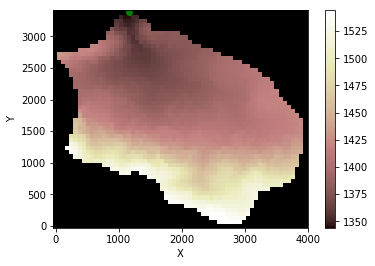

In [8]:
#Visualise Outlet node:

monitor_links = rmg.links_at_node[outlet_node]
imshow_grid(rmg, z)
print(monitor_links)

# outlet_right = 478

plt.plot(rmg.node_x[outlet_node],rmg.node_y[outlet_node],'go')



In [9]:
## Assign storm conditions (mm/hr):

if storm_flag == '1995-11-18':
    starting_precip_mmhr = 15.6
    starting_precip_ms = starting_precip_mmhr * (2.77778 * 10 ** -7)
    storm_duration = 17100.
elif storm_flag == '1997-03-11':
    starting_precip_mmhr = 34.8
    starting_precip_ms = starting_precip_mmhr * (2.77778 * 10 ** -7)
    storm_duration = 4500.
elif storm_flag == '2009-02-10':
    starting_precip_mmhr = 18.
    starting_precip_ms = starting_precip_mmhr * (2.77778 * 10 ** -7)
    storm_duration = 7200.
elif storm_flag == '2010-12-08':
    starting_precip_mmhr = 16.8
    starting_precip_ms = starting_precip_mmhr * (2.77778 * 10 ** -7)
    storm_duration = 5400.
elif storm_flag == '2012-11-24':
    starting_precip_mmhr = 16.8
    starting_precip_ms = starting_precip_mmhr * (2.77778 * 10 ** -7)
    storm_duration = 3900.

In [10]:
#OverlandFlow Component

of = OverlandFlow(rmg, alpha = alpha, mannings_n = mannings_n, steep_slopes = True)

# plt.imshow(mannings_n.reshape((rows,cols)))
# plt.colorbar()

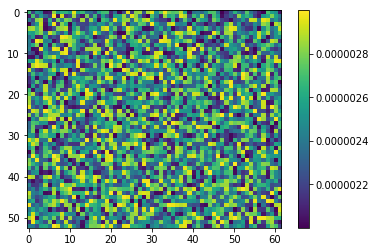

In [11]:
#Soil Infiltration Component

plt.imshow(hydraulic_conductivity.reshape((rows,cols)))
plt.colorbar()

SI = SoilInfiltrationGreenAmpt(rmg, soil_type = soil_type, hydraulic_conductivity=hydraulic_conductivity)

In [12]:
#Set lists for population:

elapsed_time = 0.0

# Lists for saving data
discharge_at_outlet_top = []
discharge_at_outlet_bottom = []
discharge_at_outlet_right = []
discharge_at_outlet_left = []

hydrograph_time = []

# Setting initial fields
rmg['node']['surface_water__discharge'] = np.zeros(rmg.number_of_nodes)

elapsed time =  0.0
elapsed time =  7200.19929938
elapsed time =  10800.5879429
elapsed time =  14401.1632288
elapsed time =  25200.3637168


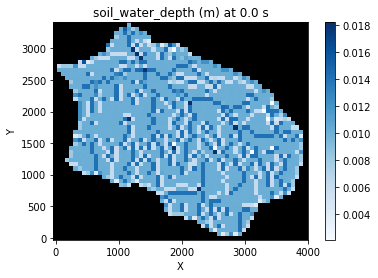

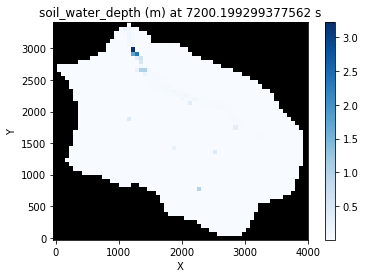

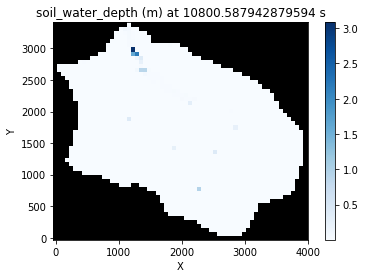

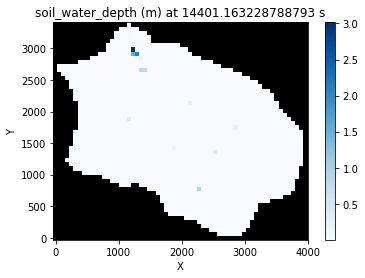

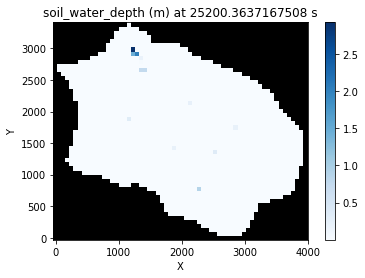

In [13]:
#Run time:

fig = 1

while elapsed_time < model_run_time:
    # Setting the adaptive time step
    of.dt = of.calc_time_step()

    # The storm starts when the model starts. While the elapsed time is less
    # than the storm duration, we add water to the system as rainfall.
    if elapsed_time < (storm_duration):
        of.rainfall_intensity =  starting_precip_ms   
    else: # elapsed time exceeds the storm duration, rainfall ceases.
        of.rainfall_intensity = 0.0

    of.overland_flow() # Generating overland flow based on the deAlmeida solution.

    # Append time and discharge to their lists to save data and for plotting.
    hydrograph_time.append(elapsed_time/3600)
#     discharge_at_outlet_right.append(np.abs(of.q[outlet_right[0]]) * rmg.dx) # append discharge in m^3/s
#     discharge_at_outlet_top.append(np.abs(of.q[monitor_links[1]]) * rmg.dx) # append discharge in m^3/s
#     discharge_at_outlet_left.append(np.abs(of.q[monitor_links[2]]) * rmg.dx) # append discharge in m^3/s
#     discharge_at_outlet_bottom.append(np.abs(of.q[monitor_links[3]]) * rmg.dx) # append discharge in m^3/s

    discharge_at_outlet_bottom.append(np.abs(of.q[outlet_link]) * rmg.dx) # append discharge in m^3/s

    SI.run_one_step(of.dt)
    
    # output time every now and then so that you know the code
    # is actually running
    if (elapsed_time % 3600) < 2:
        print('elapsed time = ',elapsed_time)
        plt.figure(fig)
        fig = fig + 1
        imshow_grid(rmg, 'surface_water__depth', cmap='Blues')
        plt.title('soil_water_depth (m) at {} s'.format(elapsed_time))

    # Updating elapsed_time
    elapsed_time += of.dt

Text(0.5,1,'soil_water_infiltration__depth (m)')

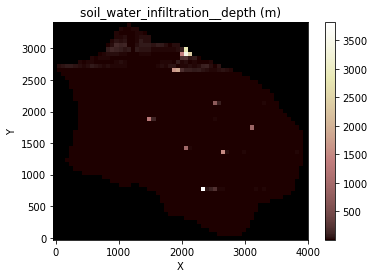

In [14]:
#Plot Soil water infiltration Depth:

plt.figure(1)
imshow_grid(rmg, 'soil_water_infiltration__depth')
plt.title('soil_water_infiltration__depth (m)')

Text(0.5,1,'OverlandFlow surface_water__depth (m)')

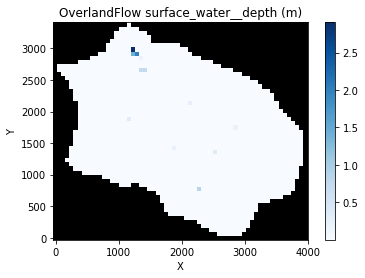

In [15]:
#Plot Surface water Depth:

plt.figure(1)
imshow_grid(rmg, 'surface_water__depth', cmap='Blues')
plt.title('OverlandFlow surface_water__depth (m)')

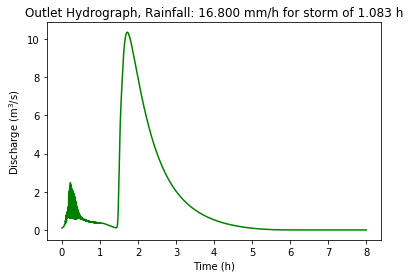

Max discharge at outlet = 10.358


In [23]:
#Plot Hydrograph:

# plt.plot(hydrograph_time, discharge_at_outlet_right, 'y', label = 'right')
# plt.plot(hydrograph_time, discharge_at_outlet_left, 'b', label = 'left')
# plt.plot(hydrograph_time, discharge_at_outlet_top, 'r', label = 'top')
plt.plot(hydrograph_time, discharge_at_outlet_bottom, 'g', label = 'bottom')
plt.xlabel('Time (h)')
plt.ylabel('Discharge (m$^3$/s)')
plt.title('Outlet Hydrograph, Rainfall: {:.3f} mm/h for storm of {:.3f} h'.format(starting_precip_mmhr, storm_duration/3600.))

plt.show()

print('Max discharge at outlet = {:.3f}'.format(max(discharge_at_outlet_bottom)))

5589
0
[ 0.02304726  0.01708511  0.01512148 ...,  0.00135335  0.00135335
  0.00135336]
0


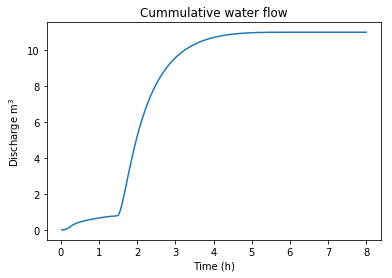

In [17]:
#Plot Cumulative water flow:

print(len(hydrograph_time))
print(len(discharge_at_outlet_top))
print(np.diff(np.array(hydrograph_time)))

tot_volume_mid = np.cumsum(np.array(discharge_at_outlet_bottom)[1:]*np.diff(np.array(hydrograph_time)))

plt.plot(hydrograph_time[1:], tot_volume_mid)
plt.title('Cummulative water flow')
plt.ylabel('Discharge m$^3$')
plt.xlabel('Time (h)')

print(sum(discharge_at_outlet_top))